# Biodiversity Intactness Index for Phoenix 

## About the notebook

**Link to *my* Biodiversity Intactness Index GitHub repository:**

https://github.com/YoselynR/EDS220-Biodiversity-Intactness-Index

## Purpose 

The purpose of this notebook is to analyze the Biodivesity Intactness Index for the years 2017 and 2020 for the Phoenix subdivision, by looking at the difference in biodiversity index that is >= 0.75. 

## Highlights
- 
- 
- 
- 

## About the data

In this task you will use three datasets: which include the shapefile for the Phoenix subdivision, and the BII data. 

### First dataset: Phoenix subdivision

The dataset for the Phoenix subdivision is from 

### Second dataset: BII 2017

### Third dataset: BII 2020



### Libraries

In [1]:
import geopandas as gpd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
from rasterio.mask import mask
from shapely.geometry import mapping

### Load in data, convert crs, and mask

In [2]:
# Load in the Phoenix subdivision shapefile
phoenix_shapefile = gpd.read_file("data/phoenix_subdivision.shp")
# Extract the geometry of the first feature
phoenix_geometry = phoenix_shapefile.geometry.values[0]

# Load in the BII rasters for 2017 and 2020
bii_2017_path = "data/bii_2017_34.74464974521749_-115.38597824385106_cog.tif"
bii_2020_path = "data/bii_2020_34.74464974521749_-115.38597824385106_cog.tif"

In [3]:
# Convert geometry to GeoJSON-like dict format required by rasterio.mask
geometry = [phoenix_geometry.__geo_interface__]

# Open the 2017 BII raster
with rasterio.open(bii_2017_path) as src_2017:
    bii_2017_data, out_transform = mask(src_2017, geometry, crop=True)
    bii_2017_meta = src_2017.meta  # Metadata for the raster
    raster_crs = src_2017.crs  # Get CRS from the raster file

# Open the 2020 BII raster
with rasterio.open(bii_2020_path) as src_2020:
    bii_2020_data, out_transform = mask(src_2020, geometry, crop=True)
    bii_2020_meta = src_2020.meta
    raster_crs = src_2020.crs  # Get CRS from the raster file

# Print CRS
print(f"CRS of 2017 BII raster: {raster_crs}")
print(f"CRS of 2017 BII raster: {raster_crs}")

CRS of 2017 BII raster: EPSG:4326
CRS of 2017 BII raster: EPSG:4326


In [4]:
# Get shapefile crs and print
shapefile_crs = phoenix_shapefile.crs
print(f"CRS of Phoenix shapefile: {shapefile_crs}")
# Reproject shapefile CRS to match raster CRS if not already the same
if shapefile_crs != 'EPSG:4326':
    phoenix_shapefile = phoenix_shapefile.to_crs(epsg=4326)
    print(f"Reprojected shapefile CRS to: EPSG:4326")

CRS of Phoenix shapefile: EPSG:4269
Reprojected shapefile CRS to: EPSG:4326


### Plot

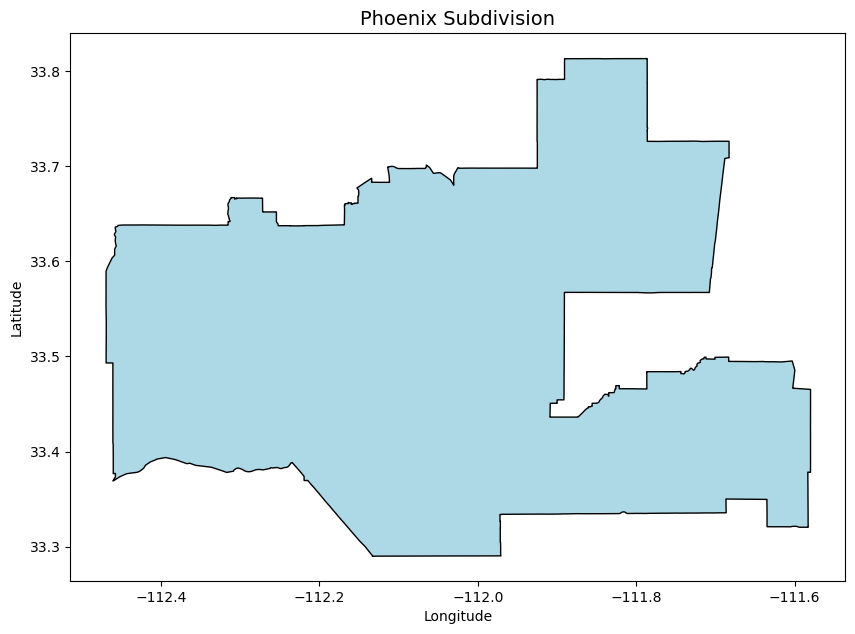

In [5]:
# Plot the Phoenix subdivision
fig, ax = plt.subplots(figsize=(10, 10))  # Larger plot for better readability
phoenix_shapefile.plot(ax=ax, color='lightblue', edgecolor='black')
# Add title and labels
ax.set_title("Phoenix Subdivision", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
# Show the plot
plt.show()

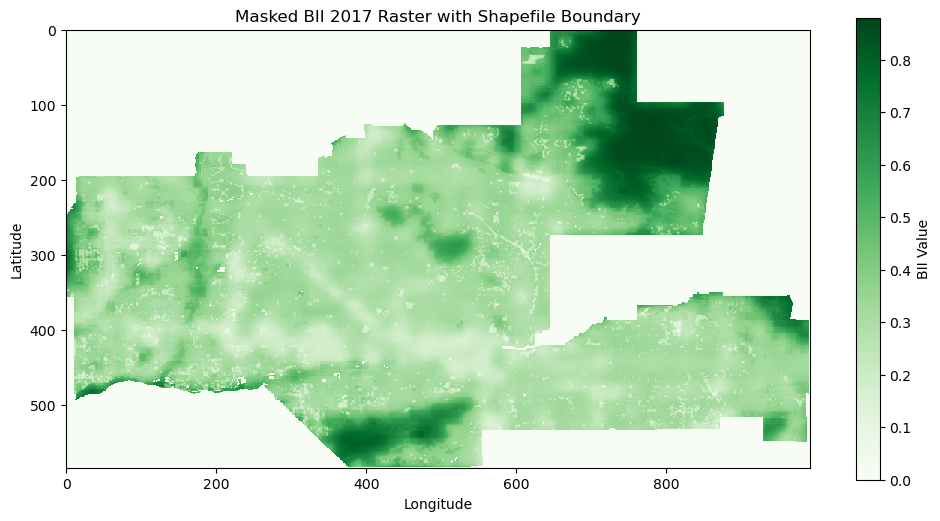

In [18]:
# Plotting the masked raster using Matplotlib
plt.figure(figsize=(12, 6))  # Adjust the figure size 
# Plot the masked raster (bii_2020_data) - this is a 2D array
plt.imshow(bii_2017_data[0], cmap='Greens', interpolation='none')  # Greens for color map
plt.colorbar(label='BII Value')  # Color bar for reference
# Add title and labels
plt.title("Masked BII 2017 Raster with Shapefile Boundary")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
# Show the plot
plt.show()

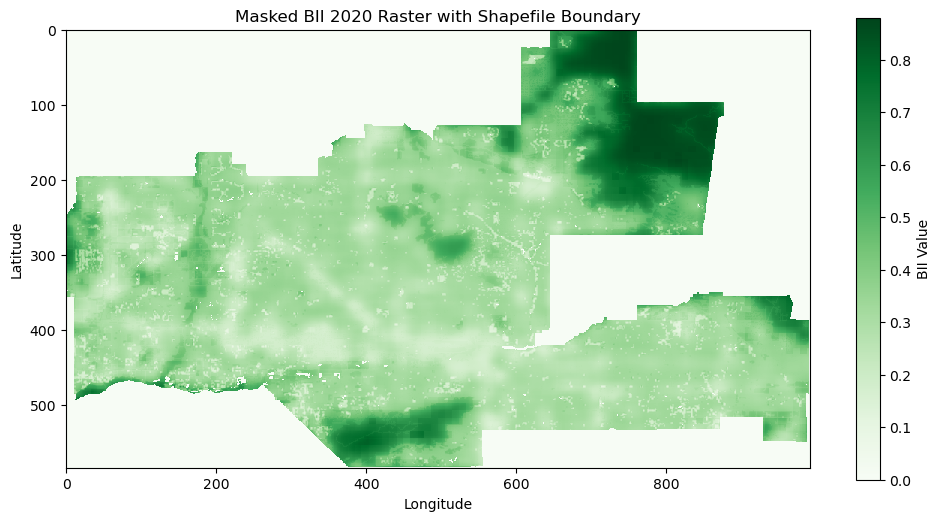

In [32]:
# Plotting the masked raster using Matplotlib
plt.figure(figsize=(12, 6))  # Adjust the figure size 
# Plot the masked raster (bii_2020_data) - this is a 2D array
plt.imshow(bii_2020_data[0], cmap='Greens', interpolation='none')  # Greens for color map
plt.colorbar(label='BII Value')  # Color bar for reference
# Add title and labels
plt.title("Masked BII 2020 Raster with Shapefile Boundary")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
# Show the plot
plt.show()

### Calculate percentage change of biodiversity >= 0.75 from 2017 to 2020

In [8]:
threshold = 0.75
bii_mask_2017 = bii_2017_data[0] >= threshold
bii_mask_2020 = bii_2020_data[0] >= threshold

In [9]:
valid_pixels_2017 = np.isfinite(bii_2017_data[0])
valid_pixels_2020 = np.isfinite(bii_2020_data[0])
valid_bii_mask_2017 = bii_mask_2017 & valid_pixels_2017
valid_bii_mask_2020 = bii_mask_2020 & valid_pixels_2020
total_valid_pixels_2017 = np.sum(valid_pixels_2017) 
total_valid_pixels_2020 = np.sum(valid_pixels_2020)
masked_pixels_2017 = np.sum(valid_bii_mask_2017) 
masked_pixels_2020 = np.sum(valid_bii_mask_2020)
percentage_2017 = (masked_pixels_2017 / total_valid_pixels_2017) * 100
percentage_2020 = (masked_pixels_2020 / total_valid_pixels_2020) * 100
percentage_difference = percentage_2017 - percentage_2020
print(f"Percentage of Phoenix area in 2017 with BII >= 0.75: {percentage_2017:.2f}%")
print(f"Percentage of Phoenix area in 2020 with BII >= 0.75: {percentage_2020:.2f}%")
print(f"Percentage of Phoenix area in 2020 with BII >= 0.75: {percentage_difference:.2f}%")

Percentage of Phoenix area in 2017 with BII >= 0.75: 4.17%
Percentage of Phoenix area in 2020 with BII >= 0.75: 3.80%
Percentage of Phoenix area in 2020 with BII >= 0.75: 0.37%


### Plot

(-0.5, 991.5, 583.5, -0.5)

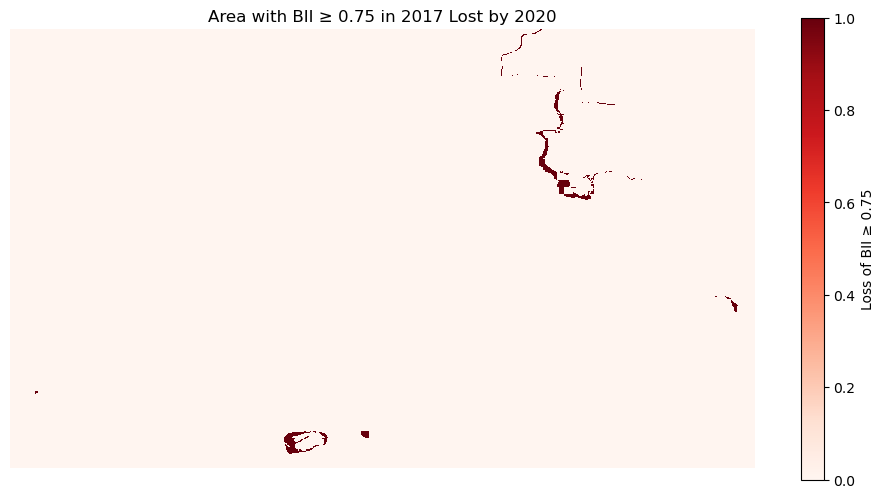

In [19]:
# Identify areas with BII ≥ 0.75 in 2017 that have lost that condition by 2020
bii_total_loss = (bii_mask_2017 == 1) & (bii_mask_2020 == 0)

# Plot the result
plt.figure(figsize=(12, 6))
plt.imshow(bii_total_loss, cmap='Reds', interpolation='nearest')
plt.title("Area with BII ≥ 0.75 in 2017 Lost by 2020")
plt.colorbar(label="Loss of BII ≥ 0.75")
plt.axis('off')

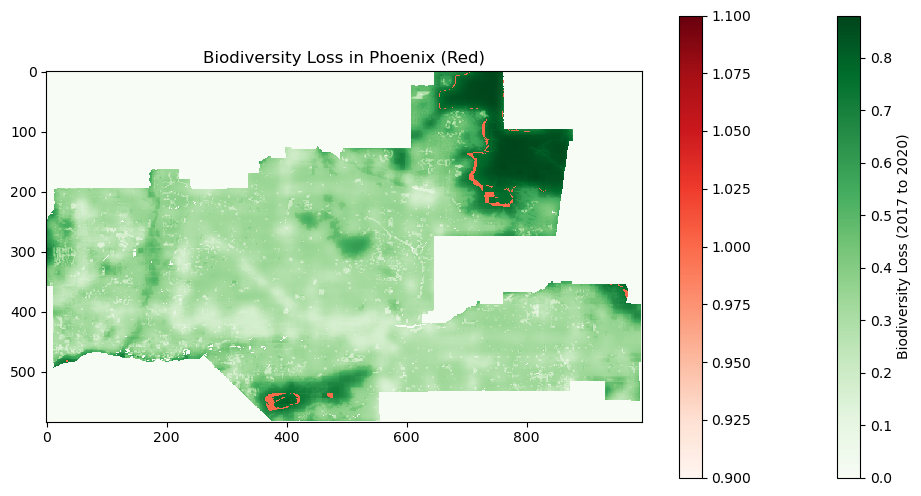

In [34]:
# Prepare loss mask
total_loss_mask = np.where(bii_total_loss, 1, np.nan) # Set true value to 1

# Plot base layer
plt.figure(figsize=(12, 6))
plt.imshow(bii_2020_data[0], cmap="Greens", interpolation="none", label="Biodiversity Intactness (2020)")
plt.colorbar(label="Biodiversity Loss (2017 to 2020)")
# Plot 
plt.imshow(total_loss_mask, cmap="Reds", interpolation="nearest")
plt.title("Biodiversity Loss in Phoenix (Red)")
plt.colorbar()
plt.show()